# import dependencies

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import mlflow
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings("ignore")
import json

In [11]:
data = pd.read_csv("../Data/cleaned_data.csv", parse_dates=['date'])
data = data.sort_values('date')

# Split Data


In [26]:
train_size = int(len(data)*0.8)

#train_data = data .iloc[:train_data]
#test_data = data.iloc[train_size]

# Feature Selection with Mutual Info

In [14]:
mi_data = data.drop(columns=['date', 'hospital_id','ward_code'])

<Axes: ylabel='Feature'>

<Figure size 1000x800 with 0 Axes>

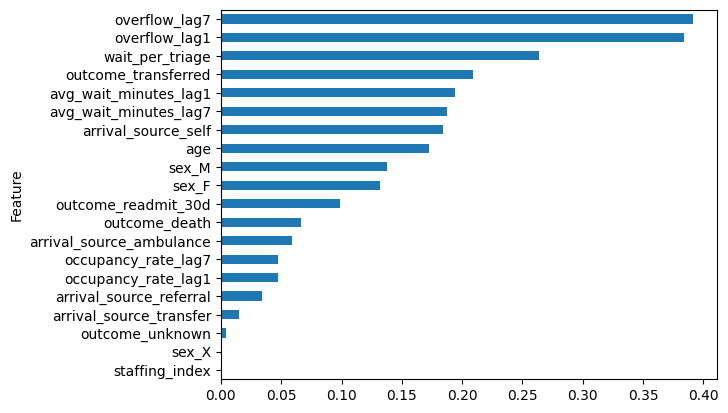

In [22]:
target = mi_data['admissions']
var = mi_data.drop(columns=['admissions'])

mi_scores = mutual_info_regression(var, target,  random_state=42)
mi_df = pd.DataFrame(
    {
    'Feature' : var.columns,
    'MI_Score' : mi_scores
    }
).sort_values('MI_Score', ascending=True)

plt.figure(figsize=(10,8))
mi_df.head(20).plot(x='Feature', y='MI_Score', kind='barh',legend=False)


# Split data with external features sampled on daily basis

In [39]:
top_features = mi_df['Feature'].head(20).to_list()

data = pd.get_dummies(data, columns=['ward_code'], drop_first=False)

bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

ward_cols = [col for col in data.columns if col.startswith('ward_code_')]

exog_features = top_features + ['hospital_id'] + ward_cols

data = data.set_index('date')



weekly_target = data['admissions'].resample('W').mean()
weekly_exog = data[exog_features].resample('W').mean()

train_size = int(len(weekly_target) * 0.8)

X_train = weekly_exog.iloc[:train_size]
y_train = weekly_target.iloc[:train_size]

X_test = weekly_exog.iloc[train_size:]
y_test = weekly_target.iloc[train_size:]

In [40]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

125 125 32 32


# Train SARIMAX using MLFLOW

In [ ]:
mlflow.set_experiment('Hospital Admissions Forcasting')

2025/12/03 19:55:18 INFO mlflow.tracking.fluent: Experiment with name 'Hospital Admissions Forcasting' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/asus/Medoptix-Analytics/model/mlruns/351235710047961421', creation_time=1764791718740, experiment_id='351235710047961421', last_update_time=1764791718740, lifecycle_stage='active', name='Hospital Admissions Forcasting', tags={}>

32
sarimax_mae: 0.4634489811673108
sarimax_rmse: 0.5528139854889483
sarimax_r2: 0.884034274151503


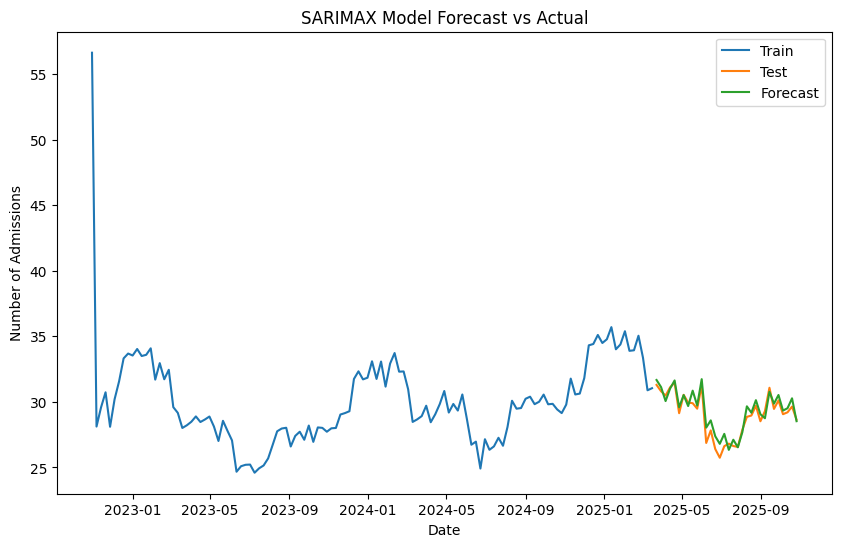

In [46]:
with mlflow.start_run(run_name="SARIMAX model"):

    # Fit model
    sarimax_model = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(1,1,1),
        seasonal_order=(2,0,2,7)
    ).fit(disp=False)

    print(len(y_test))

    # Forecast correctly
    sarimax_forecast = sarimax_model.forecast(
        steps=len(y_test),
        exog=X_test
    )

    # Metrics
    sarimax_mae = mean_absolute_error(y_test, sarimax_forecast)
    sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_forecast))
    sarimax_r2 = r2_score(y_test, sarimax_forecast)

    print("sarimax_mae:", sarimax_mae)
    print("sarimax_rmse:", sarimax_rmse)
    print("sarimax_r2:", sarimax_r2)

    # Log parameters
    mlflow.log_param('order', (2,0,3))
    mlflow.log_param('seasonal_order', (0,0,0,7))
    mlflow.log_param('exogenous_features', exog_features)

    # Log metrics
    mlflow.log_metric('MAE', sarimax_mae)
    mlflow.log_metric('RMSE', sarimax_rmse)
    mlflow.log_metric('R2_score', sarimax_r2)

    # Save the model correctly
    with open('sarimax_model.pkl', 'wb') as f:
        pickle.dump(sarimax_model, f)

    with open("sarimax_schema.json", "w") as f:
        json.dump(exog_features, f)

    mlflow.log_artifact('sarimax_model.pkl')
    mlflow.log_artifact('sarimax_schema.json')

    # Plot forecast
    plt.figure(figsize=(10,6))
    plt.plot(y_train.index, y_train, label='Train')
    plt.plot(y_test.index, y_test, label='Test')
    plt.plot(y_test.index, sarimax_forecast, label='Forecast')  
    plt.legend()
    plt.title('SARIMAX Model Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Number of Admissions')

    plt.savefig('sarimax_forecast.png')
    mlflow.log_artifact('sarimax_forecast.png')

    plt.show()


# Hyper Parameter Tuning using Auto ARIMA

In [44]:
from pmdarima import auto_arima

model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=7,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    
    stepwise=False, 
    random=True,  
    n_fits=30,   
    random_state=42 
)

print(model.summary())
print(f"Best order: {model.order}")
print(f"Best seasonal_order: {model.seasonal_order}")

 ARIMA(2,0,3)(0,0,0)[7] intercept   : AIC=614.331, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=679.978, Time=0.01 sec
 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,2)(1,0,1)[7] intercept   : AIC=631.588, Time=0.18 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=632.284, Time=0.14 sec
 ARIMA(1,0,3)(0,0,1)[7] intercept   : AIC=614.838, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=633.932, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=633.203, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=659.962, Time=0.15 sec
 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=618.335, Time=0.17 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=616.628, Time=0.40 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=618.732, Time=1.55 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=617.702, Time=0.25 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=616.751, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept